In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

2023-05-18 02:09:18.547907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 02:09:18.627348: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 02:09:18.972982: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/andres/installROOT/lib
2023-05-18 02:09:18.973023: W tensorflow/compiler/xla/stre

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load Data

In [5]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 50

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

In [6]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
17206
17206
17206
17206
17206
17206
17206
17206

 Signal Events
12157
12157
12157
12157
12157
12157
12157
12157


In [7]:
######################
# ONLY HITS_bot DATA #
######################

# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
num_data = 10000



hits_bot_B = np.array( f_B['HITS_bot/ev_1'] )
hits_bot_S = np.array( f_S['HITS_bot/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_bot_B = np.row_stack([hits_bot_B,np.array( f_B['HITS_bot/ev_'+str(i)] )])
    hits_bot_S = np.row_stack([hits_bot_S,np.array( f_S['HITS_bot/ev_'+str(i)] )])
    
    
    
# close the h5 files
f_B.close()
f_S.close()



# X and Y for the classifier
X_mon = np.row_stack([hits_bot_B,hits_bot_S])
# normalize
X_mon = scaler.fit_transform(X_mon)

del hits_bot_B
del hits_bot_S

# labels
y_mon = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (9999, 121)
y_mon_train :  (9999,)
X_mon_val :  (3334, 121)
y_mon_val :  (3334,)
X_mon_test :  (6667, 121)
y_mon_test :  (6667,)



### CLASSIFIER

[0]	validation_0-error:0.32823	validation_0-logloss:0.67572	validation_0-map:0.67601	validation_1-error:0.35693	validation_1-logloss:0.67903	validation_1-map:0.66135
[1]	validation_0-error:0.28273	validation_0-logloss:0.66020	validation_0-map:0.72320	validation_1-error:0.31764	validation_1-logloss:0.66644	validation_1-map:0.70450
[2]	validation_0-error:0.26833	validation_0-logloss:0.64650	validation_0-map:0.73711	validation_1-error:0.30144	validation_1-logloss:0.65496	validation_1-map:0.71949
[3]	validation_0-error:0.25483	validation_0-logloss:0.63327	validation_0-map:0.74907	validation_1-error:0.29034	validation_1-logloss:0.64467	validation_1-map:0.73942
[4]	validation_0-error:0.24712	validation_0-logloss:0.62149	validation_0-map:0.75756	validation_1-error:0.28314	validation_1-logloss:0.63542	validation_1-map:0.73788
[5]	validation_0-error:0.24352	validation_0-logloss:0.61070	validation_0-map:0.76187	validation_1-error:0.27804	validation_1-logloss:0.62663	validation_1-map:0.74245


/home/andres/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/andres/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-error:0.23602	validation_0-logloss:0.60081	validation_0-map:0.76608	validation_1-error:0.28194	validation_1-logloss:0.61929	validation_1-map:0.74114
[7]	validation_0-error:0.23592	validation_0-logloss:0.59156	validation_0-map:0.76918	validation_1-error:0.28104	validation_1-logloss:0.61223	validation_1-map:0.74602
[8]	validation_0-error:0.23162	validation_0-logloss:0.58317	validation_0-map:0.77115	validation_1-error:0.27984	validation_1-logloss:0.60611	validation_1-map:0.74798
[9]	validation_0-error:0.23132	validation_0-logloss:0.57544	validation_0-map:0.77461	validation_1-error:0.27774	validation_1-logloss:0.59976	validation_1-map:0.74790
[10]	validation_0-error:0.22732	validation_0-logloss:0.56816	validation_0-map:0.77728	validation_1-error:0.27504	validation_1-logloss:0.59446	validation_1-map:0.74972
[11]	validation_0-error:0.22532	validation_0-logloss:0.56135	validation_0-map:0.78004	validation_1-error:0.27415	validation_1-logloss:0.58952	validation_1-map:0.75000
[1

[56]	validation_0-error:0.19142	validation_0-logloss:0.44908	validation_0-map:0.80691	validation_1-error:0.26155	validation_1-logloss:0.53802	validation_1-map:0.75187
[57]	validation_0-error:0.19142	validation_0-logloss:0.44842	validation_0-map:0.80725	validation_1-error:0.26125	validation_1-logloss:0.53798	validation_1-map:0.75211
[58]	validation_0-error:0.19092	validation_0-logloss:0.44759	validation_0-map:0.80749	validation_1-error:0.26155	validation_1-logloss:0.53781	validation_1-map:0.75224
[59]	validation_0-error:0.19042	validation_0-logloss:0.44691	validation_0-map:0.80783	validation_1-error:0.26215	validation_1-logloss:0.53768	validation_1-map:0.75250
[60]	validation_0-error:0.18972	validation_0-logloss:0.44641	validation_0-map:0.80800	validation_1-error:0.26185	validation_1-logloss:0.53756	validation_1-map:0.75261
[61]	validation_0-error:0.18952	validation_0-logloss:0.44610	validation_0-map:0.80804	validation_1-error:0.26245	validation_1-logloss:0.53755	validation_1-map:0.7526

[106]	validation_0-error:0.17352	validation_0-logloss:0.42402	validation_0-map:0.81669	validation_1-error:0.26215	validation_1-logloss:0.53849	validation_1-map:0.75427
[107]	validation_0-error:0.17292	validation_0-logloss:0.42336	validation_0-map:0.81715	validation_1-error:0.26095	validation_1-logloss:0.53853	validation_1-map:0.75411
[108]	validation_0-error:0.17272	validation_0-logloss:0.42313	validation_0-map:0.81722	validation_1-error:0.26035	validation_1-logloss:0.53853	validation_1-map:0.75411
[109]	validation_0-error:0.17252	validation_0-logloss:0.42273	validation_0-map:0.81757	validation_1-error:0.26035	validation_1-logloss:0.53873	validation_1-map:0.75433
[110]	validation_0-error:0.17112	validation_0-logloss:0.42197	validation_0-map:0.81790	validation_1-error:0.26125	validation_1-logloss:0.53882	validation_1-map:0.75423
[111]	validation_0-error:0.17102	validation_0-logloss:0.42142	validation_0-map:0.81826	validation_1-error:0.26095	validation_1-logloss:0.53900	validation_1-map:

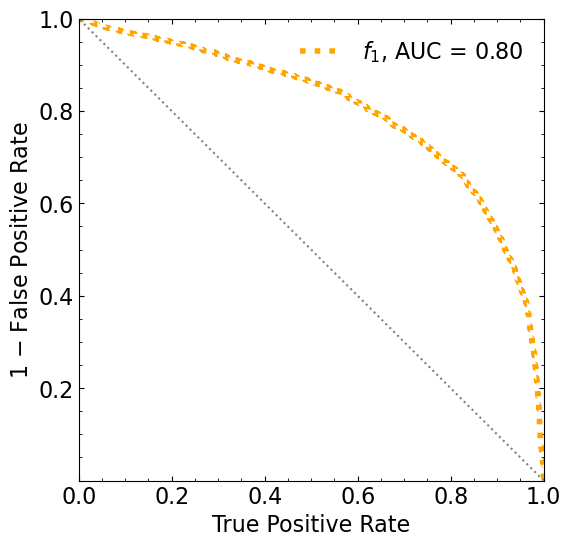

In [8]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        eval_metric=["error", "logloss", "map"],early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

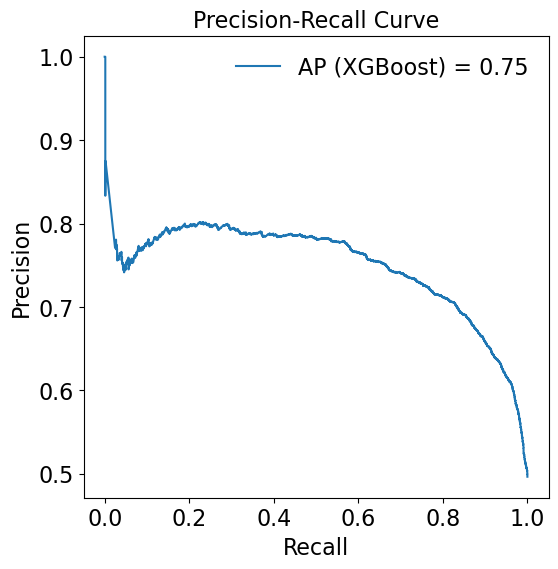

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_xg, recall_xg, _ = precision_recall_curve(y_mon_test, y_pred_xg)
auc_xg = auc(recall_xg, precision_xg)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_xg, precision_xg, label=f'AP (XGBoost) = {auc_xg:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

Accuracy: 74.11%


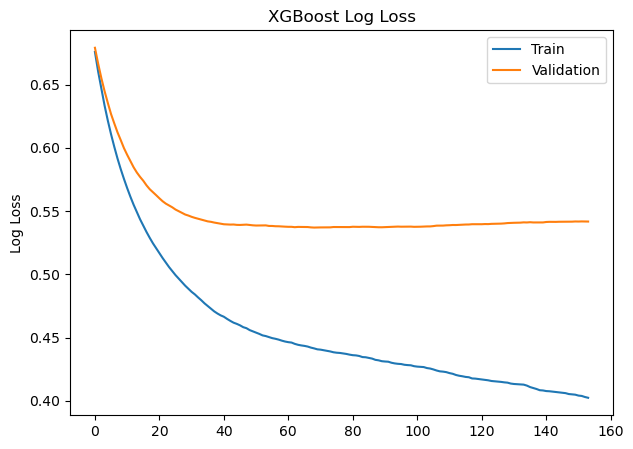

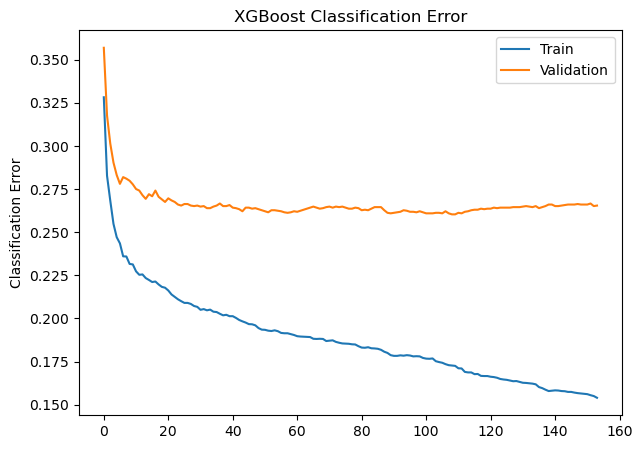

In [10]:
predictions = [round(value) for value in y_pred_xg]
accuracy = accuracy_score(y_mon_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)


# plot log loss
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Validation")
ax.legend()
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.show()

# plot classification error
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Validation")
ax.legend()
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

Classification score:


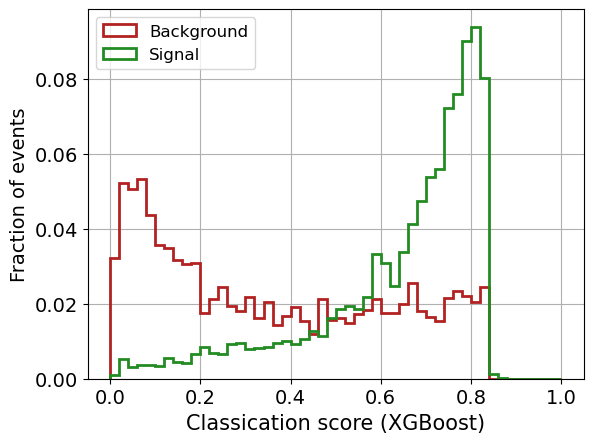

In [11]:
# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()